In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats, signal
import matplotlib.pyplot as plt

# Regression of Friedlingstein feedback eqn

dU = beta * dC + gamma * dT

regress -dU against dC, slope = beta and intercept = gamma * dT

In [185]:
GCP = pd.read_csv("./../../Prelim_Data_Analysis/gcb_data/budget.csv",
                  index_col=0,
                  skipfooter=1,
                  usecols=[0,4,5,6]
                 )
GCP['CO2'] = pd.read_csv("./../co2_temp_data/co2/co2_global.csv", index_col=0, header=0)[2:]
GCP['land sink'] = -GCP['land sink']
GCP['ocean sink'] = -GCP['ocean sink']
GCP['budget imbalance'] = -GCP["budget imbalance"] + GCP['land sink']
GCP.rename(columns={"ocean sink": "ocean",
                    "land sink": "land (model)",
                    "budget imbalance": "land"
                   },
           inplace=True)
GCP.head()

/home/student.unimelb.edu.au/rursino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


,ocean,land (model),land,CO2
Year,,,,
1959,-0.852376,-0.516073,-1.376389,315.486
1960,-0.819017,-1.394030,-1.916752,316.163
1961,-0.714842,-0.605098,-1.818860,316.856
1962,-0.756709,-1.348349,-2.307954,317.558
1963,-0.904997,-0.877794,-2.233127,318.268


In [186]:
C = GCP.CO2
C.head()

Year
1959    315.486
1960    316.163
1961    316.856
1962    317.558
1963    318.268
Name: CO2, dtype: float64

In [187]:
land = -GCP.land
land.head()

Year
1959    1.376389
1960    1.916752
1961    1.818860
1962    2.307954
1963    2.233127
Name: land, dtype: float64

In [192]:
ocean = -GCP.ocean
ocean.head()

Year
1959    0.852376
1960    0.819017
1961    0.714842
1962    0.756709
1963    0.904997
Name: ocean, dtype: float64

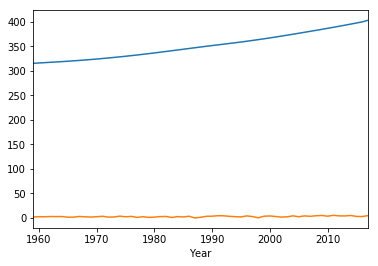

In [6]:
C.plot(); land.plot()

In [7]:
pd.DataFrame([C, land])

Year,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
CO2,315.486000,316.163000,316.85600,317.558000,318.268000,318.997000,319.757000,320.560000,321.410000,322.31000,...,382.892000,384.927000,386.995000,389.101000,391.248000,393.435000,395.651000,397.886000,400.130000,403.522500
land,1.376389,1.916752,1.81886,2.307954,2.233127,2.277164,0.922264,1.054875,2.384113,1.71958,...,3.880837,4.444837,3.036445,4.738535,3.624237,3.528228,4.410669,2.531232,2.358355,4.106298


In [8]:
stats_info = stats.linregress(C-280, land)
stats_info

LinregressResult(slope=0.023930300605221336, intercept=0.5764234984647114, rvalue=0.5358735325843046, pvalue=1.2206527776897123e-05, stderr=0.004993951437733341)

In [9]:
beta = stats_info[0] # slope = beta
intercept = stats_info[1]
beta, intercept

(0.023930300605221336, 0.5764234984647114)

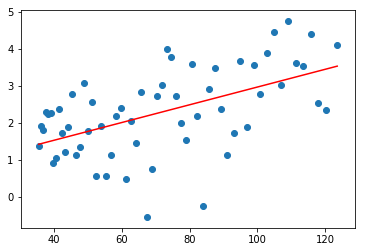

In [10]:
y = beta*(C-280)+ intercept
plt.plot(C-280,y, color='r')
plt.scatter(C-280, land)

In [11]:
# dT around 1 degC
gamma = intercept/1

In [12]:
beta, gamma

(0.023930300605221336, 0.5764234984647114)

Caveats:
- make sure that the values of C, land and dT are correct in accordance to feedback analysis in Friedlingstein2003.
- temperature has changed over the years too, can't just assign dT to one value. It means that temperature influences uptake non-linearly. Could we 'adjust' this by implementing the dT for each year (which would increase the intercept incremently each year)?

# Calculating beta and detecting depatures from linear

Calculate a linear beta using the rolling gradient function, which calculates a time series of the trend of uptake against CO2 (effectively beta). If this timeseries is non-linear, then something else could be driving uptake

In [13]:
land.loc[1959:1959+10]

Year
1959    1.376389
1960    1.916752
1961    1.818860
1962    2.307954
1963    2.233127
1964    2.277164
1965    0.922264
1966    1.054875
1967    2.384113
1968    1.719580
1969    1.204671
Name: land, dtype: float64

LinregressResult(slope=0.02879814903541788, intercept=-55.517280847692106, rvalue=0.9708966153199413, pvalue=4.5163482440701956e-37, stderr=0.0009409311183714584)

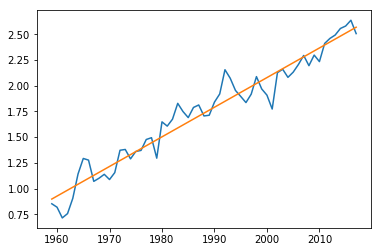

In [14]:
plt.plot(ocean)
plt.plot(ocean.index, stats.linregress(ocean.index, ocean.values)[0]*ocean.index + stats.linregress(ocean.index, ocean.values)[1])
stats.linregress(ocean.index, ocean.values)

In [151]:
def rolling_trend(x, window_size=25, plot=False):

    roll_vals = []
    for i in range(0, len(x.index) - window_size):
        sub = x.iloc[i:i+window_size+1]

        linreg = stats.linregress(sub.index, sub.values.squeeze())

        roll_vals.append(linreg[0])


    roll_df = pd.DataFrame({f"{window_size}-year trend slope": roll_vals}, index=x.index[:-window_size])

    if plot:

        plt.figure(figsize=(22,16))

        plt.subplot(211)
        plt.plot(x)
        plt.ylabel("C flux to the atmosphere (GtC)", fontsize=20)

        plt.subplot(212)
        plt.plot(roll_df, color='g')
        plt.ylabel("Slope of C flux trend (GtC/ppm/yr)", fontsize=20)           

    return roll_df

In [152]:
def bandpass(x, fc, fs=1, order=5, btype="low", deseasonalise_first=False):

    if deseasonalise_first:
        mean_list = []
        for i in range(12):
            indices = range(i, len(x)+i, 12)
            sub = x[indices]
            mean_list.append(np.mean(sub))

        s = []
        for i in range(int(len(x)/12)):
            for j in mean_list:
                s.append(j)
        s = np.array(s)

        x = x - (s-np.mean(s))

    if btype == "band":
        assert type(fc) == list, "fc must be a list of two values."
        fc = np.array(fc)

    w = fc / (fs / 2) # Normalize the frequency.
    b, a = signal.butter(order, w, btype)

    return signal.filtfilt(b, a, x)

/home/student.unimelb.edu.au/rursino/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


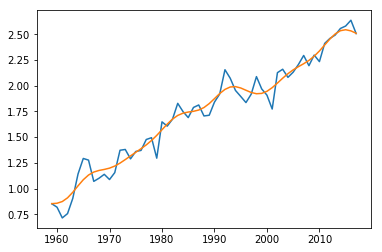

In [153]:
plt.plot(ocean)
plt.plot(ocean.index, bandpass(ocean, 1/10))

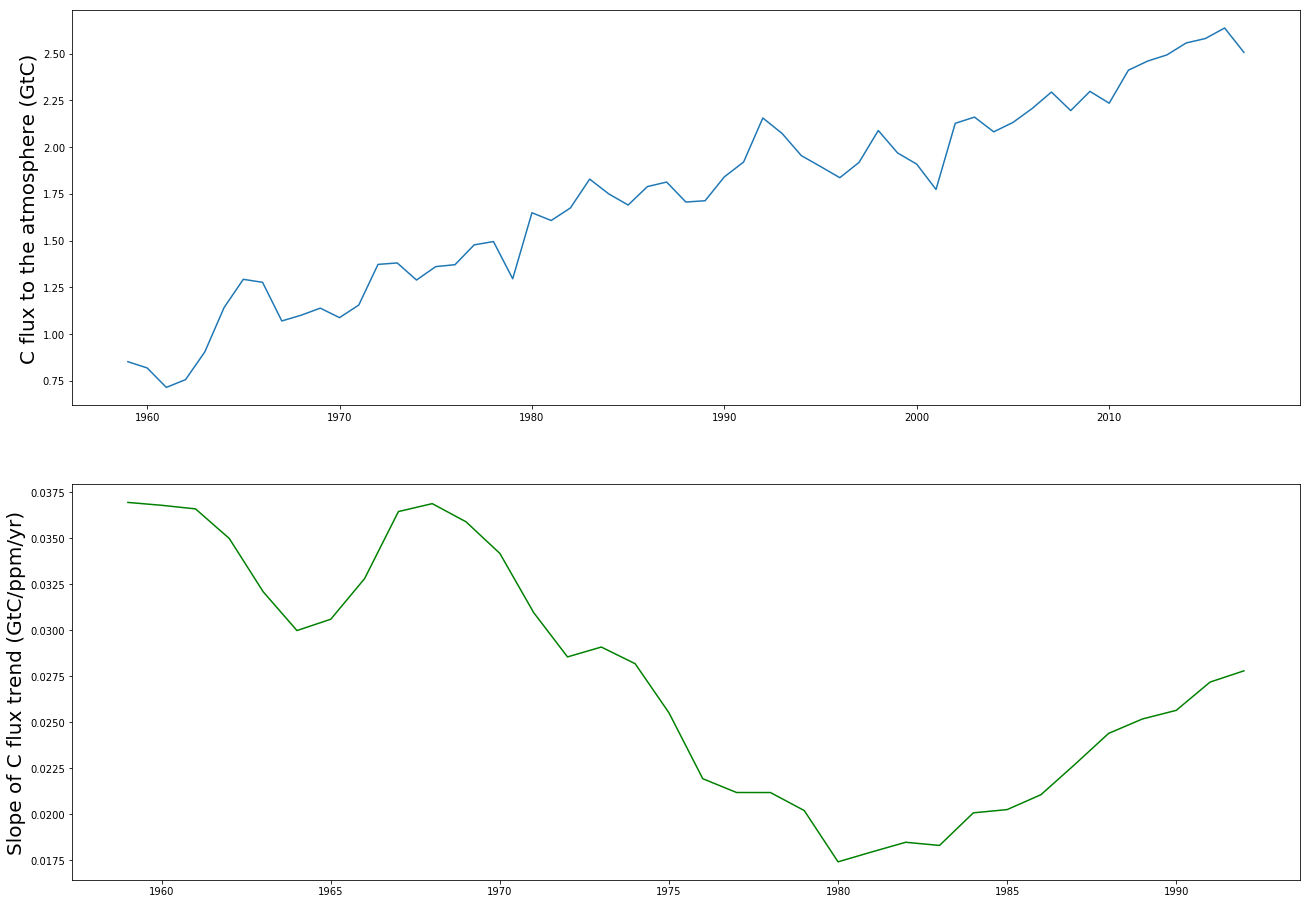

In [154]:
rolling_trend(ocean, window_size=25, plot=True);

In [155]:
bandpass(land.values, 1/10)

array([1.3804123 , 1.66632813, 1.88824554, 2.00453467, 2.00575862,
       1.9158778 , 1.78243625, 1.65978395, 1.59168677, 1.59917282,
       1.67671552, 1.79658422, 1.91891247, 2.00414898, 2.02465912,
       1.97274371, 1.86289446, 1.72697077, 1.60283579, 1.51985503,
       1.48712664, 1.49035111, 1.49995517, 1.48769309, 1.44426708,
       1.38919924, 1.36709682, 1.43029536, 1.61424889, 1.91639649,
       2.28919533, 2.65245054, 2.92088187, 3.03495217, 2.98118792,
       2.79368172, 2.5377774 , 2.28473419, 2.08875167, 1.97496377,
       1.94124127, 1.97055854, 2.04641058, 2.16307662, 2.32599171,
       2.54321053, 2.81349223, 3.11768781, 3.41814884, 3.66733798,
       3.82307738, 3.86496735, 3.80540054, 3.68986713, 3.58471564,
       3.55526054, 3.64160625, 3.84188652, 4.11102464])

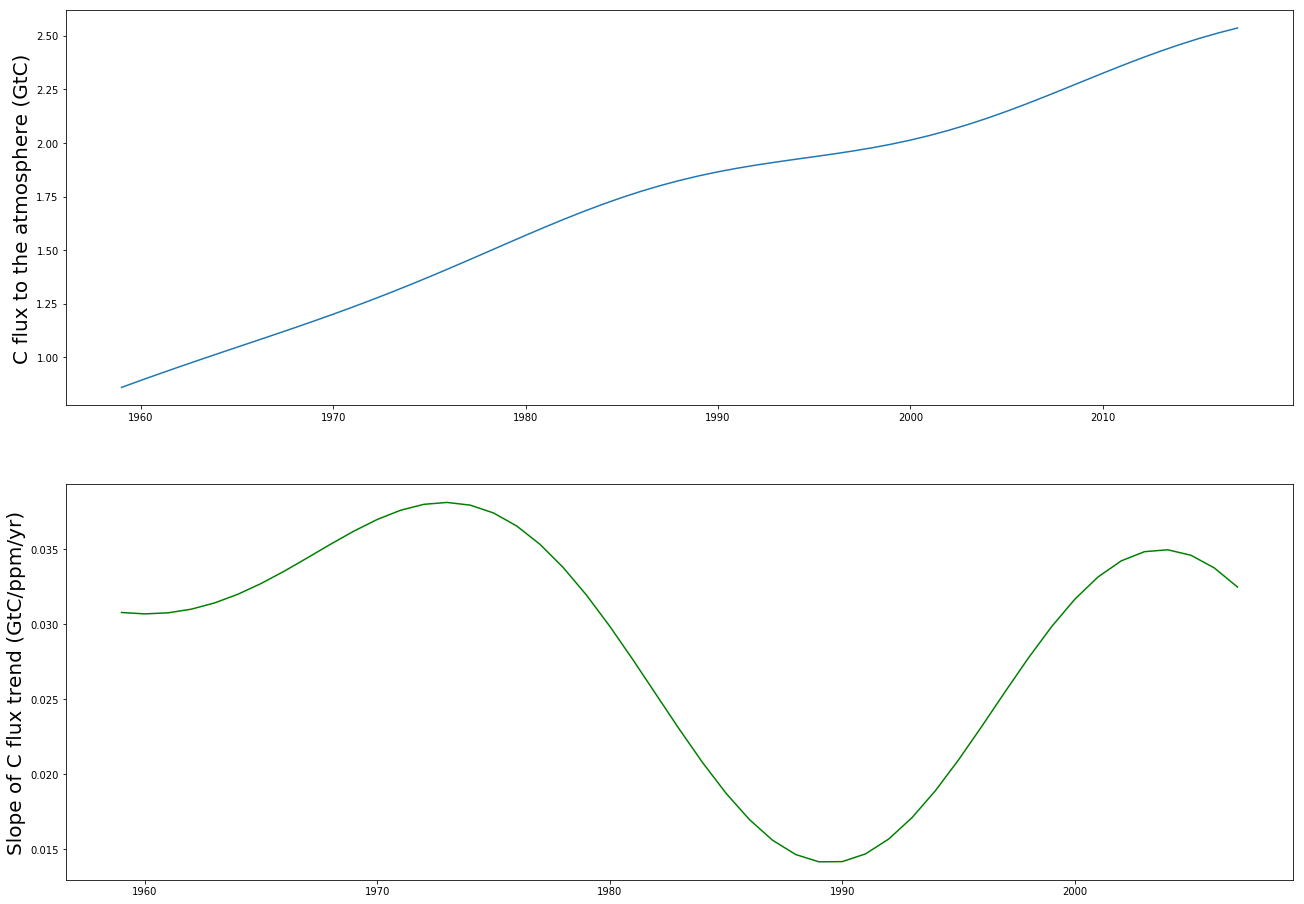

In [156]:
rolling_trend(pd.DataFrame({"vals": bandpass(ocean, 1/25)}, index=land.index),
              window_size=10,
              plot=True
             );

In [172]:
roll_ocean_10 = rolling_trend(ocean, window_size=10, plot=False)
roll_ocean_25 = rolling_trend(ocean, window_size=25, plot=False)

lt = stats.linregress(ocean.index, ocean)
roll_ocean_lt = np.ones(len(ocean.values))*lt[0]

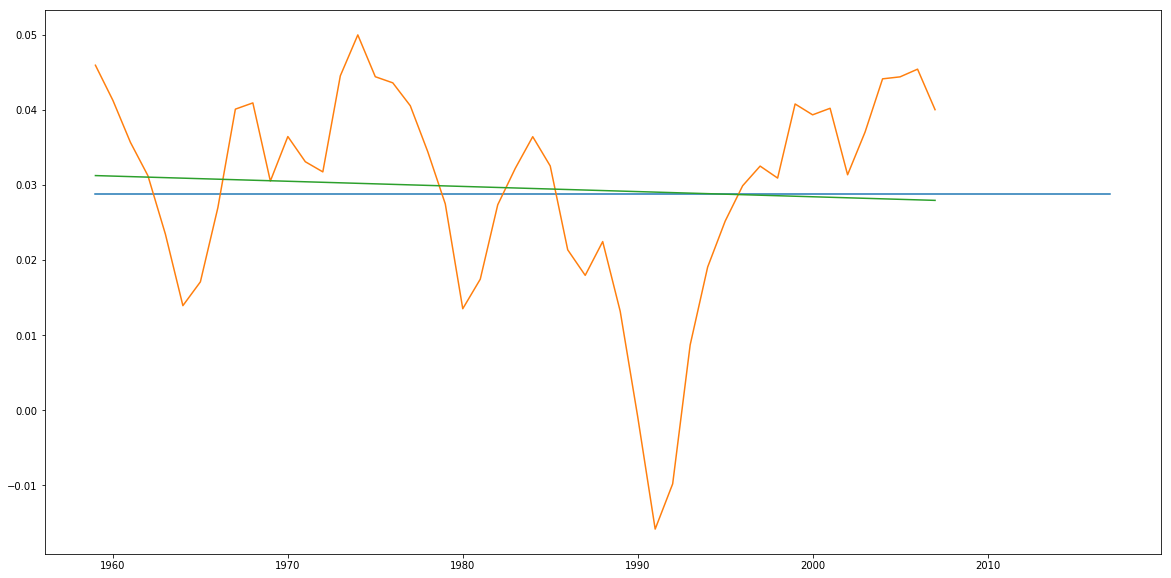

In [173]:
plt.figure(figsize=(20,10))
plt.plot(ocean.index, roll_ocean_lt)
plt.plot(roll_ocean_10)
stat = stats.linregress(roll_ocean_10.index, roll_ocean_10.values.squeeze())
plt.plot(roll_ocean_10.index, stat[0]*roll_ocean_10.index + stat[1])

In [179]:
0.5*roll_ocean_lt[0], 0.5*roll_ocean_lt[0]/stats.linregress(C, temp_med)[0]

(0.01439907451770894, 1.5208615206510765)

In [217]:
landd = land.copy()
for i in range(len(landd)-1):
    landd.iloc[i+1] += landd.iloc[i]

In [218]:
CC = C.copy()-280

In [223]:
stat = stats.linregress(CC, landd)
stat

LinregressResult(slope=1.4457766136123156, intercept=-44.83949590349591, rvalue=0.9979074666110624, pvalue=1.692536731398452e-69, stderr=0.01240787411519597)

In [220]:
stats.linregress(C, land)

LinregressResult(slope=0.02393030060522134, intercept=-6.124060670997264, rvalue=0.5358735325843047, pvalue=1.2206527776897004e-05, stderr=0.00499395143773334)

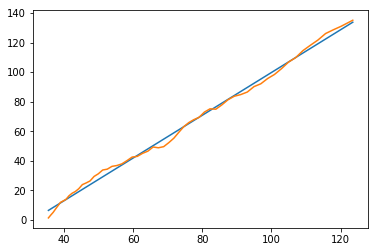

In [221]:
plt.plot(CC.values, stat[0]*CC.values+stat[1])
plt.plot(CC.values, landd.values)

In [225]:
stat[0]*0.5, stat[0]*0.5 / stats.linregress(CC, temp_med)[0]

(0.7228883068061578, 76.3530328423514)

# Non-linear fits

2nd degree poly

In [52]:
co = np.polyfit(C-280, -ocean, 2)
y = co[0]*(C-280)**2 + co[1]*(C-280)+co[2]

In [53]:
np.diff(y)

array([-0.01951679, -0.01985762, -0.01999129, -0.02009195, -0.02049656,
       -0.02122462, -0.02226629, -0.02339132, -0.0245675 , -0.02570944,
       -0.02678853, -0.02772468, -0.02862508, -0.02948818, -0.03023575,
       -0.03097099, -0.03176607, -0.03263885, -0.03343521, -0.03398732,
       -0.03428152, -0.03430679, -0.03416857, -0.03396519, -0.03369947,
       -0.03330949, -0.03282412, -0.03218703, -0.03140907, -0.03032032,
       -0.02912209, -0.02805623, -0.0272287 , -0.02684679, -0.02689532,
       -0.0272668 , -0.02768448, -0.02808535, -0.02837868, -0.02848431,
       -0.02839669, -0.02822029, -0.02801671, -0.0277092 , -0.02723315,
       -0.02658999, -0.02586124, -0.02506693, -0.02428379, -0.02351676,
       -0.02282185, -0.0221262 , -0.02139873, -0.02059513, -0.01963061,
       -0.01853709, -0.01733685, -0.02378455])

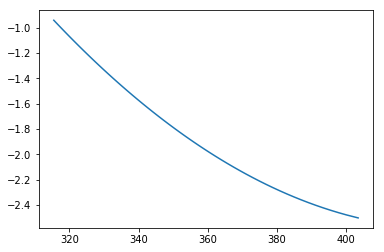

In [54]:
plt.plot(C, y)

In [ ]:
plt.plot(C[1:], np.diff(y))

# Ordinary Least Squares Regression

Need uptake, CO2 and temp. at same temporal resolution (either annual or monthly where data is deseasonalised).
Perform OLS using statsmodels.

Unlike from before Lit Review, we will need to perform this as a rolling gradient with 10 year window sizes.

In [103]:
import statsmodels.api as sm

In [104]:
temp_med = pd.read_csv("./../co2_temp_data/temp/HADCRUT4_annual.txt", delim_whitespace=True,
                       index_col="Year", skipfooter=1
                      )
temp_med = temp_med["Ann"]+14
temp_med

/home/student.unimelb.edu.au/rursino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


Year
1959    14.017
1960    13.951
1961    14.038
1962    14.014
1963    14.048
1964    13.777
1965    13.860
1966    13.932
1967    13.926
1968    13.887
1969    14.032
1970    13.973
1971    13.814
1972    13.935
1973    14.062
1974    13.786
1975    13.851
1976    13.759
1977    14.047
1978    13.938
1979    14.057
1980    14.092
1981    14.140
1982    14.011
1983    14.194
1984    13.986
1985    13.970
1986    14.045
1987    14.192
1988    14.198
1989    14.118
1990    14.296
1991    14.254
1992    14.105
1993    14.148
1994    14.208
1995    14.325
1996    14.183
1997    14.390
1998    14.539
1999    14.306
2000    14.294
2001    14.441
2002    14.496
2003    14.505
2004    14.447
2005    14.545
2006    14.506
2007    14.491
2008    14.395
2009    14.506
2010    14.560
2011    14.425
2012    14.470
2013    14.514
2014    14.579
2015    14.763
2016    14.797
2017    14.677
Name: Ann, dtype: float64

In [113]:
x = np.column_stack((C,temp_med))
x = sm.add_constant(x, prepend=True)

results = sm.OLS(land.values,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     22.27
Date:                Wed, 05 Feb 2020   Prob (F-statistic):           7.64e-08
Time:                        14:36:36   Log-Likelihood:                -75.027
No. Observations:                  59   AIC:                             156.1
Df Residuals:                      56   BIC:                             162.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.8153     12.461      3.436      0.001      17.852      67.779
x1             0.0666      0.012      5.712      0.000       0.043       0.090
x2            -4.5016      1.137     -3.959      0.000      -6.779      -2.224
==============================================================================
Omnibus:                        1.974   Durbin-Watson:                   1.371
Prob(Omnibus):                  0.373   Jarque-Bera (JB):                1.391
Skew:                          -0.368   Prob(JB):                        0.499
Kurtosis:                       3.159   Cond. No.                     3.83e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

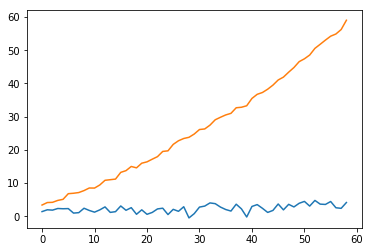

In [121]:
plt.plot(land.values)
plt.plot(42.8153+0.666*(C-280).values-4.5016*temp_med.values)

# Other works

In [76]:
x1 = np.array([321,322,324,325,326,328])
x2 = np.array([12,14,13,15,13,16])
y = np.array([1,3,2,5,6,8])

In [78]:
stats.linregress(x1,y), stats.linregress(x2,y)

(LinregressResult(slope=0.9500000000000001, intercept=-303.95, rvalue=0.9293203772845852, pvalue=0.00731686971873861, stderr=0.18874586088176867),
 LinregressResult(slope=1.4, intercept=-15.2, rvalue=0.7807492414280213, pvalue=0.06683655258985782, stderr=0.5602197371087115))

In [84]:
np.sum(x2*y)/np.sum(x2*x2)

0.3114754098360656

In [85]:
np.mean(y) - np.sum(x2*y)/np.sum(x2*x2) * np.mean(x2)

-0.14207650273224015

In [123]:
stats.linregress(C, temp_med)

LinregressResult(slope=0.009467709138662891, intercept=10.871557502549196, rvalue=0.9240552304848763, pvalue=1.7763886346112844e-25, stderr=0.0005187609193719807)

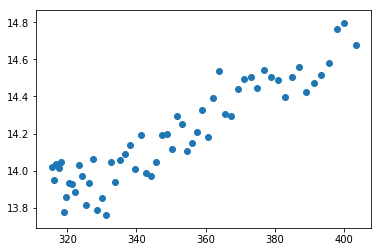

In [126]:
plt.scatter(C, temp_med)